# Part 1: Find Predictors of Influence

<font face = "Tahoma" size = 3> 
Jake Johnson (jpj753), Christian Alfonso (ca35748), Abhinav Sharma (ass2575)  
    
The dataset for Part I can be found <a href = http://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network> here</a>. 
Use the training dataset only to build and validate your model. Each observation in the dataset describes two individuals, A and B.<br><br>
    There are 11 variables for each person based on Twitter activity, e.g., number of followers, retweets, network characteristics, etc. <br><br>Each observation shows whether A > B (Choice = “1”) or B > A (Choice = “0”). 


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import re
#from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import networkx as nx

<font face = "Tahoma" size = 3> Read data and feature processing

In [2]:
df = pd.read_csv('train.csv')
df.columns
df.head()

,Choice,A_follower_count,A_following_count,A_listed_count,A_mentions_received,A_retweets_received,A_mentions_sent,A_retweets_sent,A_posts,A_network_feature_1,...,B_following_count,B_listed_count,B_mentions_received,B_retweets_received,B_mentions_sent,B_retweets_sent,B_posts,B_network_feature_1,B_network_feature_2,B_network_feature_3
0,0,228,302,3,0.583979,0.100503,0.100503,0.100503,0.362150,2,...,29808,1689,15.430498,3.984029,8.204331,0.332423,6.988815,66,75.530303,1916.893939
1,0,21591,1179,228,90.456506,25.798292,5.709329,1.111159,5.176620,369,...,848,1610,40.495021,8.943607,3.227677,0.564343,1.070321,163,132.030675,2931.515337
2,0,7310,1215,101,25.503644,9.556347,5.361519,0.591206,3.589718,95,...,482,206,0.734696,0.354379,0.603202,0.100503,0.603202,3,10.333333,277.333333
3,0,20,7,2,7.690824,0.277306,1.331508,0.100503,2.830627,6,...,17637,278,572.874856,390.293681,27.552040,7.167557,32.101906,1762,23.469296,1395.845634
4,1,45589,862,2641,148.854279,36.998884,27.881768,3.333492,23.861282,551,...,1711,181,21.601866,3.581661,6.764657,1.119727,4.563246,85,48.500000,1993.627907


<font face = "Tahoma" size = 3> Business hypothesis
<br><br>
The features that might be indicative of social media influence are :
- Follower counts 
- Listed counts 
- Mentions received 
- Retweets received
- Number of posts
- Network features 1,2 and 3


In [3]:
# create A-B dataframe
diff_df = pd.DataFrame(df['Choice'])
for i in range(1,12):
    diff_df['Diff_' + df.columns[i][2:]] = df[df.columns[i]] - df[df.columns[i+11]]
    
diff_df.head()

,Choice,Diff_follower_count,Diff_following_count,Diff_listed_count,Diff_mentions_received,Diff_retweets_received,Diff_mentions_sent,Diff_retweets_sent,Diff_posts,Diff_network_feature_1,Diff_network_feature_2,Diff_network_feature_3
0,0,-34235,-29506,-1686,-14.846518,-3.883525,-8.103828,-0.231920,-6.626665,-64,90.969697,9438.106061
1,0,-17671,331,-1382,49.961485,16.854685,2.481652,0.546816,4.106299,206,-113.587704,-1601.149290
2,0,3688,733,-105,24.768949,9.201969,4.758317,0.490702,2.986516,92,58.594502,5722.563574
3,0,-19542,-17630,-276,-565.184032,-390.016375,-26.220532,-7.067053,-29.271279,-1756,-21.469296,-1299.678967
4,1,38035,-849,2460,127.252413,33.417223,21.117111,2.213765,19.298035,466,78.904293,840.220036


In [4]:
# create A/B dataframe
ratio_df = pd.DataFrame(df['Choice'])
for i in range(1,12):
    ratio_df['A/B_' + df.columns[i][2:]] = df[df.columns[i]] / df[df.columns[i+11]].replace(to_replace=0,value=.01)
    
ratio_df.head()

,Choice,A/B_follower_count,A/B_following_count,A/B_listed_count,A/B_mentions_received,A/B_retweets_received,A/B_mentions_sent,A/B_retweets_sent,A/B_posts,A/B_network_feature_1,A/B_network_feature_2,A/B_network_feature_3
0,0,0.006616,0.010132,0.001776,0.037846,0.025227,0.012250,0.302336,0.051819,0.030303,2.204413,5.923645
1,0,0.549921,1.390330,0.141615,2.233769,2.884551,1.768866,1.968943,4.836513,2.263804,0.139687,0.453815
2,0,2.018222,2.520747,0.490291,34.713213,26.966469,8.888426,5.882446,5.951102,31.666667,6.670436,21.634244
3,0,0.001022,0.000397,0.007194,0.013425,0.000711,0.048327,0.014022,0.088176,0.003405,0.085218,0.068895
4,1,6.035081,0.503799,14.591160,6.890807,10.330091,4.121682,2.977058,5.229015,6.482353,2.626893,1.421453


In [5]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

<font face = "Tahoma" size = 3> Which set of data works best?
<br><br>

In [6]:
# normal data
x = df[df.columns[1:]].values
y = df['Choice'].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=2000).fit(X_train, y_train)
pred = logreg.predict(X_test)

# A-B data
x_d = diff_df[diff_df.columns[1:]].values
y_d = diff_df['Choice'].values
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x_d, y_d, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter=2000).fit(X_train_d, y_train_d)
pred_diff = logreg.predict(X_test_d)

# A/B data
x_r = ratio_df[ratio_df.columns[1:]].values
y_r = ratio_df['Choice'].values
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(x_r, y_r, test_size=0.3, random_state=0)
logreg_ratio = LogisticRegression(max_iter=2000).fit(X_train_r, y_train_r)
pred_ratio = logreg.predict(X_test_r)

C:\Users\jjake\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
print('Accuracy of logistic regression full data: {:f}'.format(accuracy_score(y_test,pred)))
print('Accuracy of logistic regression classifier A-B: {:f}'.format(accuracy_score(y_test,pred_diff)))
print('Accuracy of logistic regression classifier A/B: {:f}'.format(accuracy_score(y_test,pred_ratio)))

Accuracy of logistic regression full data: 0.732727
Accuracy of logistic regression classifier A-B: 0.737576
Accuracy of logistic regression classifier A/B: 0.411515


#### It appears that the A-B data performs slightly better than the normal data, next we will find the important variables and fit a best model

In [8]:
#Stats model for p-values with all data
logit_model=sm.Logit(y_train_d,X_train_d)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.567764
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3850
Model:                          Logit   Df Residuals:                     3839
Method:                           MLE   Df Model:                           10
Date:                Mon, 14 Feb 2022   Pseudo R-squ.:                  0.1804
Time:                        22:48:32   Log-Likelihood:                -2185.9
converged:                       True   LL-Null:                       -2667.0
Covariance Type:            nonrobust   LLR p-value:                2.599e-200
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.557e-07   3.42e-08     -4.547      0.000   -2.23e-07   -8.86e-08
x2          1.284e-06   6.26e

The important variables are x1,x3,x5,x7,x9,x11 based on pvalues. 
This corresponds to Diff_follower_count, Diff_listed_count, Diff_retweets_received, Diff_retweets_sent, Diff_network_feature_1, Diff_network_feature_3

In [9]:
diff_df.columns

Index(['Choice', 'Diff_follower_count', 'Diff_following_count',
       'Diff_listed_count', 'Diff_mentions_received', 'Diff_retweets_received',
       'Diff_mentions_sent', 'Diff_retweets_sent', 'Diff_posts',
       'Diff_network_feature_1', 'Diff_network_feature_2',
       'Diff_network_feature_3'],
      dtype='object')

In [53]:
# saving important coefficients for later
important_params = result.params
p = [0,2,4,6,8,10]
ip = list(important_params[p])
index_ip = diff_df.columns.to_numpy()
p2 = [1,3,5,7,9,11]
index_ip = list(index_ip[p2])

In [11]:
# performing predictions on the full datdaset using A-B dataset with dropped unimportant variables
yb = diff_df['Choice'].values
Xb = diff_df[diff_df.columns[[1,3,5,7,9,11]]].values

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.3, random_state=42)
model_best = LogisticRegression().fit(X_train_b, y_train_b)

pred_best = model_best.predict(X_test_b)
confusion_matrix = confusion_matrix(y_test_b, pred_best)
# print(confusion_matrix)
accuracy_score(y_test_b, pred_best)

0.7515151515151515

Confusion Matrix:

Text(0.5, 257.44, 'Predicted label')

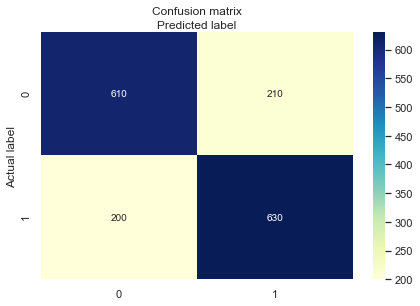

In [12]:
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Financial Value of Model

<font face = "Tahoma" size = 3> Assumptions
<br><br>
There is a difference between an influencer's value to product promotion versus a non-influencer and we hope to understand the financial difference between them based on the following assumptions
- Influencer Post gives 0.01 percent chance of follower purchasing product 
- Profit margin 10 dollars per unit
- One customer only buys one unit
- Influencer posts twice buying probability is 0.015 percent
- Without analytics 5 dollars to each person to tweet once
- With analytics 10 dollars to identified influencers to tweet twice and non influencers get no money

In [13]:
profit_margin = 10
payout = 5
payout_analytics = 10
prob_infl = 0.0001
prob_infl2 = 0.00015

In [14]:
def profit_analytics(pred,accurate,a_f, b_f):
    result = []
    for i in range(len(pred)):
        if(pred[i]==1.0 and accurate[i]==True): # actual influencer A
            pA = (a_f[i] * prob_infl2 * profit_margin) - payout_analytics
            result.append(pA)
        elif(pred[i]==0.0 and accurate[i]==True): # actual influencer B
            pB = (b_f[i] * prob_infl2 * profit_margin) - payout_analytics
            result.append(pB)
        else: # misclassified
            result.append(-payout_analytics)
    return result

In [16]:
df_profit = pd.DataFrame([y_test, pred, X_test[:,0], X_test[:,11]], index = ['actual', 'pred', 'A_follow', 'B_follow']).T
df_profit['Accurate'] = df_profit['actual'] == df_profit['pred']
df_profit.head()

,actual,pred,A_follow,B_follow,Accurate
0,1.0,0.0,366460.0,85138.0,False
1,1.0,0.0,3166413.0,489.0,False
2,1.0,1.0,1404323.0,4363.0,True
3,0.0,0.0,362.0,14838.0,True
4,1.0,1.0,48711.0,750.0,True


In [17]:
# calculate profit based on analytics
p_analytics = profit_analytics(df_profit["pred"], df_profit["Accurate"], df_profit["A_follow"], df_profit["B_follow"])
df_profit["Profit Analytics"] = p_analytics

In [18]:
# calculate profit based on perfect analytics
df_profit['dummy'] = (df_profit['actual']==df_profit['actual'])
perf_analytics = profit_analytics(df_profit["actual"], df_profit["dummy"], df_profit["A_follow"], df_profit["B_follow"])
df_profit['Profit PerfAnalytics'] = perf_analytics

In [19]:
# profit w/out analytics
df_profit['Profit NoAnalytics'] = (df_profit['actual']*df_profit['A_follow']*prob_infl*profit_margin)+(abs(df_profit['actual']-1)*df_profit['B_follow']*prob_infl*profit_margin)-(payout*2)
df_profit.head()

,actual,pred,A_follow,B_follow,Accurate,Profit Analytics,dummy,Profit PerfAnalytics,Profit NoAnalytics
0,1.0,0.0,366460.0,85138.0,False,-10.0000,True,539.6900,356.460
1,1.0,0.0,3166413.0,489.0,False,-10.0000,True,4739.6195,3156.413
2,1.0,1.0,1404323.0,4363.0,True,2096.4845,True,2096.4845,1394.323
3,0.0,0.0,362.0,14838.0,True,12.2570,True,12.2570,4.838
4,1.0,1.0,48711.0,750.0,True,63.0665,True,63.0665,38.711


In [20]:
# summarize results
print("Profit of Current Strategy: ", '${:,.2f}'.format(sum(df_profit['Profit NoAnalytics'])))
print("Profit using analytics: ", '${:,.2f}'.format(sum(df_profit['Profit Analytics'])))
print("Profit with perfect analytics: ", '${:,.2f}'.format(sum(df_profit['Profit PerfAnalytics'])))
print("Lift with our model: {}".format(sum(df_profit['Profit Analytics'])/sum(df_profit['Profit NoAnalytics'])))
print("Lift of perfect model: {}".format(sum(df_profit['Profit PerfAnalytics'])/sum(df_profit['Profit NoAnalytics'])))

Profit of Current Strategy:  $1,516,770.70
Profit using analytics:  $2,072,837.82
Profit with perfect analytics:  $2,283,406.05
Lift with our model: 1.3666125190180944
Lift of perfect model: 1.5054391873579267


# Part 2: Building a Network of Influencers

In [21]:
# read in csv of tweets
jr = pd.read_csv("covidTweets.csv", encoding= 'latin1')
jr.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers
0,0,TrySmallBiz: RT @TrySmallBiz: Drug stocks like...,0,0,2022-02-14 22:48:03+00:00,michaelrosa1979,525,NaN,411,3365
1,1,#Canada #Police #Arrest holdout protesters at ...,0,0,2022-02-14 22:48:02+00:00,TheGlobalHerald,0,Latest news and opinion from The Global Herald...,7,318
2,2,"@posglen @TheRealHoarse @LeviStraussCo Yeah, T...",0,0,2022-02-14 22:48:00+00:00,derikv,34100,"VO, Foodie, faux Politco, Proud LIB! My BFF is...",5001,837
3,3,RT @Laissonslespre1: Â«Â Crime de haute trahis...,0,94,2022-02-14 22:48:00+00:00,auxerroise89,86362,zÃ¨bre polyvalente,1455,1218
4,4,RT @legionxgroup: ð¨ #Vaccine ð¨ (#CVS pha...,0,2,2022-02-14 22:48:00+00:00,Naomi_NPM,1256,NaN,130,11


In [39]:
def interaction(message):
    interaction = []
    retweet = re.findall('RT \@[^\s\:]+',message)
    if retweet != []:
        userB = re.findall('\@[^\s\:]+',message)
        b = userB[0]
        interaction.append(b[1:])
        interaction.append('Retweet')
    else:
        interaction.append('Self')
        interaction.append('Tweet')
    return interaction # userB, interaction

In [40]:
jr['Interaction'] = jr['Message'].apply(interaction)
jr.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers,Interaction
0,0,TrySmallBiz: RT @TrySmallBiz: Drug stocks like...,0,0,2022-02-14 22:48:03+00:00,michaelrosa1979,525,NaN,411,3365,"[TrySmallBiz, Retweet]"
1,1,#Canada #Police #Arrest holdout protesters at ...,0,0,2022-02-14 22:48:02+00:00,TheGlobalHerald,0,Latest news and opinion from The Global Herald...,7,318,"[Self, Tweet]"
2,2,"@posglen @TheRealHoarse @LeviStraussCo Yeah, T...",0,0,2022-02-14 22:48:00+00:00,derikv,34100,"VO, Foodie, faux Politco, Proud LIB! My BFF is...",5001,837,"[Self, Tweet]"
3,3,RT @Laissonslespre1: Â«Â Crime de haute trahis...,0,94,2022-02-14 22:48:00+00:00,auxerroise89,86362,zÃ¨bre polyvalente,1455,1218,"[Laissonslespre1, Retweet]"
4,4,RT @legionxgroup: ð¨ #Vaccine ð¨ (#CVS pha...,0,2,2022-02-14 22:48:00+00:00,Naomi_NPM,1256,NaN,130,11,"[legionxgroup, Retweet]"


In [41]:
ntwrk = pd.DataFrame(jr['Interaction'].to_list(), columns = ['UserB', 'Interaction'])
ntwrk.insert(loc=0, column='UserA', value=jr['Username'])
ntwrk

,UserA,UserB,Interaction
0,michaelrosa1979,TrySmallBiz,Retweet
1,TheGlobalHerald,Self,Tweet
2,derikv,Self,Tweet
3,auxerroise89,Laissonslespre1,Retweet
4,Naomi_NPM,legionxgroup,Retweet
...,...,...,...
5095,CDIBrisasTurumo,CDILaA,Retweet
5096,Trostky57,Manzorro_LuisR,Retweet
5097,CDIBrisasTurumo,CDILaA,Retweet
5098,Tian_A1,Self,Tweet


In [42]:
# create network with networkx
ntwrk['nodes'] = ntwrk[['UserA', 'UserB']].apply(tuple, axis=1)

g = nx.DiGraph()  
g.add_edges_from(ntwrk['nodes'])

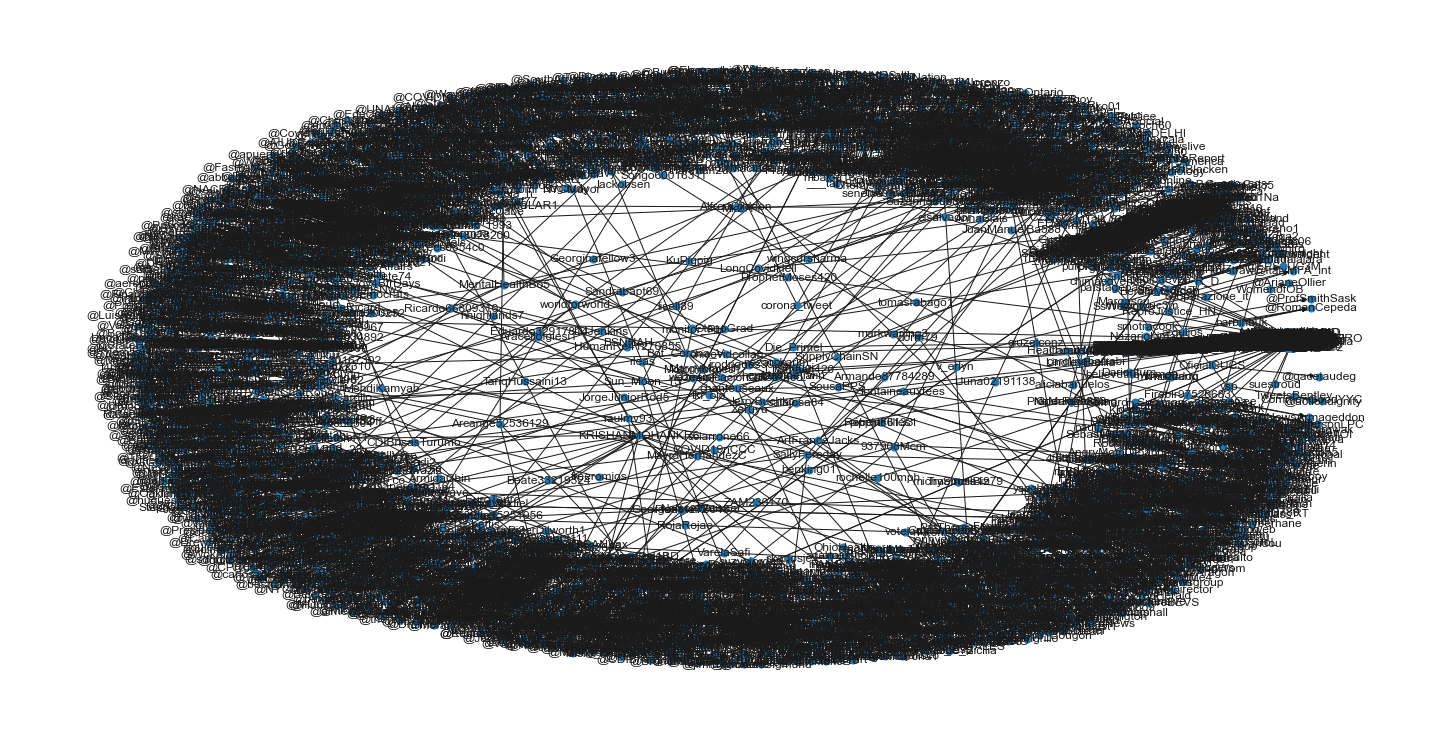

In [26]:
plt.figure(figsize = (20, 10))

nx.draw(g, with_labels = True, node_size = 50, font_size = 12)  
plt.show()

In [43]:
degree = nx.degree_centrality(g)
between = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)

In [69]:
dfn = pd.DataFrame([degree, between,close]).T
dfn.reset_index(inplace = True)
dfn.columns = ['Username','Degree','Betweenness','Closeness']
dfn.head()

,Username,Degree,Betweenness,Closeness
0,michaelrosa1979,0.000387,0.000000e+00,0.000000
1,TrySmallBiz,0.001160,7.475306e-08,0.000580
2,TheGlobalHerald,0.000193,0.000000e+00,0.000000
3,Self,0.214769,0.000000e+00,0.281805
4,derikv,0.000193,0.000000e+00,0.000000


In [60]:
#network 1 --> degree
#network 2 --> betweenness
#network 3 --> closeness
# important metrics are below

In [88]:
df_final = jr.merge(dfn, how = "left", left_on = "Username", right_on="Username")
df_final.head()

,Unnamed: 0,Message,Tweet Favorite Count,Retweet Count,Created At,Username,Likes,User Description,Following,Followers,Interaction,Degree,Betweenness,Closeness
0,0,TrySmallBiz: RT @TrySmallBiz: Drug stocks like...,0,0,2022-02-14 22:48:03+00:00,michaelrosa1979,525,NaN,411,3365,"[TrySmallBiz, Retweet]",0.000387,0.0,0.0
1,1,#Canada #Police #Arrest holdout protesters at ...,0,0,2022-02-14 22:48:02+00:00,TheGlobalHerald,0,Latest news and opinion from The Global Herald...,7,318,"[Self, Tweet]",0.000193,0.0,0.0
2,2,"@posglen @TheRealHoarse @LeviStraussCo Yeah, T...",0,0,2022-02-14 22:48:00+00:00,derikv,34100,"VO, Foodie, faux Politco, Proud LIB! My BFF is...",5001,837,"[Self, Tweet]",0.000193,0.0,0.0
3,3,RT @Laissonslespre1: Â«Â Crime de haute trahis...,0,94,2022-02-14 22:48:00+00:00,auxerroise89,86362,zÃ¨bre polyvalente,1455,1218,"[Laissonslespre1, Retweet]",0.000193,0.0,0.0
4,4,RT @legionxgroup: ð¨ #Vaccine ð¨ (#CVS pha...,0,2,2022-02-14 22:48:00+00:00,Naomi_NPM,1256,NaN,130,11,"[legionxgroup, Retweet]",0.000193,0.0,0.0


In [91]:
df_final['Score'] = df_final['Followers']*ip[0] + df_final['Following']*ip[1] + df_final['Retweet Count']*ip[2] + \
                    df_final['Tweet Favorite Count']*ip[3] + df_final['Degree']*ip[4] + df_final['Closeness']*ip[5]

In [93]:
df100 = df_final.groupby(['Username']).sum()
df100.sort_values(by='Score', ascending=False)[:10]

,Unnamed: 0,Tweet Favorite Count,Retweet Count,Likes,Following,Followers,Degree,Betweenness,Closeness,Score
Username,,,,,,,,,,
nilikm,9732,766,188,96632,17166,60986,0.061473,1.158672e-05,0.061086,78.317361
the_worldface,4573,0,5,47,368075,568109,0.000193,0.000000e+00,0.000000,39.174261
Consalud_es,9972,3,0,267939,241683,413901,0.000580,0.000000e+00,0.000000,26.016121
juank23_7,3306,164,52,7651,300,16575,0.008119,1.513750e-06,0.007926,16.405494
actualitecd,2994,164,46,2188,342,377022,0.008699,1.644567e-06,0.008506,16.354660
KRISHANMOHANKR6,9189,0,925,3033835,145000,61973,0.106515,0.000000e+00,0.000000,15.331844
Narty0071,1049,145,5,170598,4895,4487,0.001160,1.868827e-07,0.000967,15.005888
roslemusmartin,2210,105,25,71486,16516,72634,0.007346,1.345555e-06,0.006959,12.236300
CDCgov,3915,126,44,512,256,4699349,0.007539,1.414079e-06,0.007364,11.876557
